<a href="https://colab.research.google.com/github/MohamedAbuAmira/ML-DL-Examples/blob/master/multiclass_classification_on_Stack_Overflow_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example done by Mohammed Abu Amera 
https://www.linkedin.com/in/mohamedabuamira/


The dataset containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java).The task is to take a question as input, and predict the appropriate tag, in this case, Python.



In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)


2.3.0


# Sentiment analysis

## Download and explore the IMDB dataset

In [26]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

#dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')     

In [28]:
train_dir = os.path.join(os.path.dirname(dataset), 'train')
train_dir


'./train'

In [29]:
os.listdir(train_dir)

['javascript', 'python', 'csharp', 'java']

In [30]:
sample_file = os.path.join(train_dir, 'python/1004.txt')
with open(sample_file) as f:
  print(f.read())

"sharing util modules between actively developed apps we have a growing library of apps depending on a set of common util modules.  we'd like to:...share the same utils codebase between all projects.allow utils to be extended (and fixed!) by developers working on any project.have this be reasonably simple to use for devs (i.e. not a big disruption to workflow).cross-platform (no diffs for devs on macs/win/linux)...we currently do this ""manually"", with the utils versioned as part of each app.  this has its benefits, but is also quite painful to repeatedly fix bugs across a growing number of codebases.  ..on the plus side, it's very simple to deal with in terms of workflow - util module is part of each app, so on that side there is zero overhead...we also considered (fleetingly) using filesystem links or some such (not portable between os's)..i understand the implications about release testing and breakage, etc.  these are less of a problem than the mismatched utils are at the moment."

## Load the dataset

Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset. tf.data is a powerful collection of tools for working with data.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.

In [31]:
batch_size = 32
seed = 44

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [32]:
len(raw_train_ds)

200

In [33]:
for text_batch, label_batch in raw_train_ds.take(1): #take one batch
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"execute the script with special command iceweasel ( which is a firefox webbrowser for debian ) i have a problem, i would like to execute my blank script but with special command like this:..iceweasel \'info.py server.py path_install.py\'...this command must be typed on the client and we open the page with informations :..info.py (= os and ip of client).server.py.path_install.py...but i really don\'t understand where to start this ..."\n'
Label 3
Review b'"toggle elements jquery i have a three a tags on a page. user can ""select"" only one..markup:..&lt;div class=""fl_near""&gt;.  &lt;span class=""title""&gt;title&lt;/span&gt;.  &lt;p&gt;.    &lt;a id=""filter_today"" class=""first_tb"" style=""display: block""&gt;.      &lt;span&gt;text1&lt;/span&gt;.    &lt;/a&gt;.    &lt;a id=""filter_tomorrow""&gt;.      &lt;span&gt;text2&lt;/span&gt;.    &lt;/a&gt;.    &lt;a id=""filter_aftertomorrow"" class=""last_tb selected"" style=""display: block""&gt;.      &lt;span&gt;text3&lt;/spa

In [35]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


**Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.**

In [36]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [37]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


## Prepare the dataset for training

Next, you will **standardize**, **tokenize**, and **vectorize** the data using the helpful `preprocessing.TextVectorization` layer.

* **Standardization** refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.
* **Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).
* **Vectorization refers** to converting tokens into numbers so they can be fed into a neural network. 

*All of these tasks can be accomplished with this layer*

You set the output_mode to int to create unique integer indices for each token

`sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [70]:
max_features = 8000                        # here 100000 words converted to in integers
sequence_length = 400                       # Take just 250 word from every text
 
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

**Note: it's important to only use your training data when calling adapt (using the test set would leak information)**.


In [71]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.



In [72]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [73]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Q", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized Q", vectorize_text(first_review, first_label))

Q tf.Tensor(b'"removing decimals from a list in blank i would like to know if it is possible to remove the decimals from a product of a maths command in blank. my code is below. i would like to print only the whole numbers and not show the others...mylist = [5,10,15,20,25,30,35,40,45,50].myint = 7.newlist = [x / myint for x in mylist].print (newlist)"\n', shape=(), dtype=string)
Label python
Vectorized Q (<tf.Tensor: shape=(1, 400), dtype=int64, numpy=
array([[ 970, 3507,   32,    5,   57,    7,   16,    3,   66,   47,    4,
          98,   10,   11,    6,  208,    4,  278,    2, 3507,   32,    5,
         749,    9,    5, 6473,  311,    7,   16,   23,   29,    6,  167,
           3,   66,   47,    4,   79,   93,    2,  676,  184,    8,   20,
         259,    2,    1,    1,    1,   90, 6438,   12,   90,    7,    1,
        4641,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,

As you can see above, **each token has been replaced by an integer**. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [74]:
print("100 ---> ",vectorize_layer.get_vocabulary()[100])
print(" 4 ---> ",vectorize_layer.get_vocabulary()[4])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

100 --->  user
 4 --->  to
Vocabulary size: 8000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [75]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [76]:


AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [77]:
embedding_dim = 256


In [78]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2048256   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 2,049,284
Trainable params: 2,049,284
Non-trainable params: 0
_________________________________________________________________


**The layers are stacked sequentially to build the classifier:**

* The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, see the word embedding tutorial.
* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
* This fixed-length output vector is piped through a  
   fully-connected (Dense) layer with 16 hidden units.
The last layer is densely connected with a single output node.

In [82]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])


In [83]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/30
200/200 [==============================] - 14s 71ms/step - loss: 1.1318 - accuracy: 0.6280 - val_loss: 1.0745 - val_accuracy: 0.6687
Epoch 2/30
200/200 [==============================] - 14s 71ms/step - loss: 0.9737 - accuracy: 0.7075 - val_loss: 0.9406 - val_accuracy: 0.7225
Epoch 3/30
200/200 [==============================] - 14s 71ms/step - loss: 0.8363 - accuracy: 0.7525 - val_loss: 0.8393 - val_accuracy: 0.7406
Epoch 4/30
200/200 [==============================] - 14s 72ms/step - loss: 0.7297 - accuracy: 0.7822 - val_loss: 0.7670 - val_accuracy: 0.7613
Epoch 5/30
200/200 [==============================] - 14s 72ms/step - loss: 0.6475 - accuracy: 0.8072 - val_loss: 0.7159 - val_accuracy: 0.7688
Epoch 6/30
200/200 [==============================] - 14s 71ms/step - loss: 0.5814 - accuracy: 0.8305 - val_loss: 0.6782 - val_accuracy: 0.7775
Epoch 7/30
200/200 [==============================] - 14s 72ms/step - loss: 0.5258 - accuracy: 0.8492 - val_loss: 0.6498 - val_accuracy:

In [84]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 4s 18ms/step - loss: 0.6278 - accuracy: 0.7896
Loss:  0.6277535557746887
Accuracy:  0.7896249890327454


## Create a plot of accuracy and loss over time

In [85]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

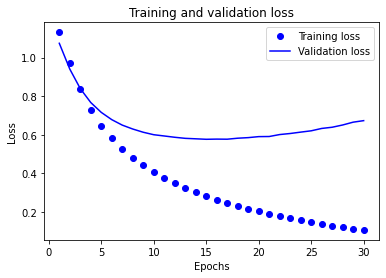

In [87]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

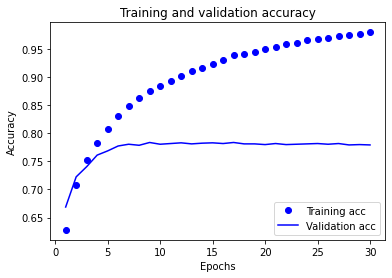

In [88]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model

In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [89]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 4s 17ms/step - loss: 0.7903 - accuracy: 0.7855
0.7854999899864197
